In [1]:
import pandas as pd
import numpy as np
import requests
import json
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from s2_key import *
from sklearn.decomposition import PCA

In [2]:
dem_df = pd.read_csv('annotated-excerpts-with-themes.csv')
dem_df = dem_df.loc[dem_df['1 = Relevant / 0 = Irrelevant'] == 1]
dem_df = dem_df.loc[dem_df['1 = Reference'] != 1]
dem_df = dem_df.loc[(dem_df['AS Explicit Theme'] == 'democratizing') | (dem_df['VG Explicit Theme'] == 'democratizing')]

In [3]:
dem_papers = set(dem_df['Corpus ID'])

In [4]:
# emb = {}

# for idx, corpusId in enumerate(dem_papers):
#     if idx % 20 == 0:
#         print(idx)

#     data = requests.get(
#         'https://api.semanticscholar.org/graph/v1/paper/CorpusID:{}?fields=embedding.specter_v2'.format(corpusId),
#         headers = {"Accept": "*/*", "x-api-key": S2_KEY}
#     ).json()
    
#     if data is not None and 'embedding' in data:
#         if data['embedding'] is not None and 'vector' in data['embedding']:
#             emb[corpusId] = np.array(data['embedding']['vector'])
#         else:
#             print(data['embedding'])
#     else:
#         print(data)

In [5]:
# X = np.array([emb[i] for i in emb])
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)
# plt.scatter(X_pca[:, 0], X_pca[:, 1])
# plt.show()

In [6]:
excerpts = dem_df['Excerpt'].tolist()

In [7]:
# API_URL = "https://api-inference.huggingface.co/models/sentence-transformers/all-MiniLM-L6-v2"
# headers = {"Authorization": f"Bearer {HF_KEY}"}

# import time

# def query(payload):
#     response = requests.post(API_URL, headers=headers, json=payload)
#     return response.json()

# sims = []
# for idx, excerpt in enumerate(excerpts):
#     if idx % 100 == 0:
#         print(idx)
      
#     data = query(
#             {
#                 "inputs": {
#                     "source_sentence": excerpt,
#                     "sentences": excerpts
#                 }
#             })
#     while len(data) < len(excerpts):
#         data = query(
#             {
#                 "inputs": {
#                     "source_sentence": excerpt,
#                     "sentences": excerpts
#                 }
#             })
#         time.sleep(1)


#     sims.append(data)

In [8]:
# excerpt_sims = np.array(sims)
# np.save('dem_excerpt_sims.npy', excerpt_sims)

In [11]:
import requests

API_URL = "https://api-inference.huggingface.co/pipeline/feature-extraction/sentence-transformers/all-mpnet-base-v2"
headers = {"Authorization": f"Bearer {HF_KEY}"}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

output = query({
    "inputs": excerpts
})

In [12]:
excerpt_emb = np.array(output)
np.save('dem_excerpt_emb.npy', excerpt_emb)

In [13]:
excerpt_emb

array([[ 0.05998861,  0.02355342, -0.00426747, ..., -0.00911802,
         0.00064819,  0.01078294],
       [ 0.00367834, -0.00569115, -0.01768124, ...,  0.03714669,
        -0.02479417, -0.03026119],
       [-0.00682248,  0.04658217, -0.00530726, ...,  0.00531658,
        -0.01696866, -0.01899602],
       ...,
       [ 0.01767769,  0.0389353 , -0.03755906, ...,  0.02268592,
        -0.01790197, -0.04300729],
       [ 0.04523036,  0.02277476, -0.02909783, ..., -0.00220397,
        -0.00293748, -0.00570161],
       [ 0.00830653, -0.0055657 , -0.0414848 , ...,  0.0073778 ,
        -0.05509804,  0.00675671]])

In [14]:
excerpt_emb = np.load('dem_excerpt_emb.npy')

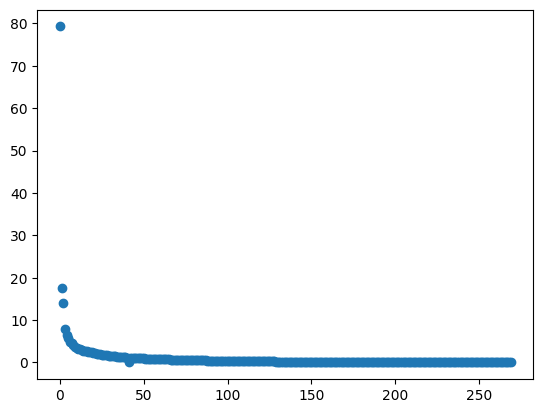

https://api.semanticscholar.org/CorpusID:257901155
https://api.semanticscholar.org/CorpusID:257378481
https://api.semanticscholar.org/CorpusID:220646526
https://api.semanticscholar.org/CorpusID:247518913
https://api.semanticscholar.org/CorpusID:244772951

https://api.semanticscholar.org/CorpusID:52124316
https://api.semanticscholar.org/CorpusID:256194532
https://api.semanticscholar.org/CorpusID:237194902
https://api.semanticscholar.org/CorpusID:218974227
https://api.semanticscholar.org/CorpusID:256460906

https://api.semanticscholar.org/CorpusID:18493970
https://api.semanticscholar.org/CorpusID:53491784
https://api.semanticscholar.org/CorpusID:220280381
https://api.semanticscholar.org/CorpusID:259138596
https://api.semanticscholar.org/CorpusID:219310188



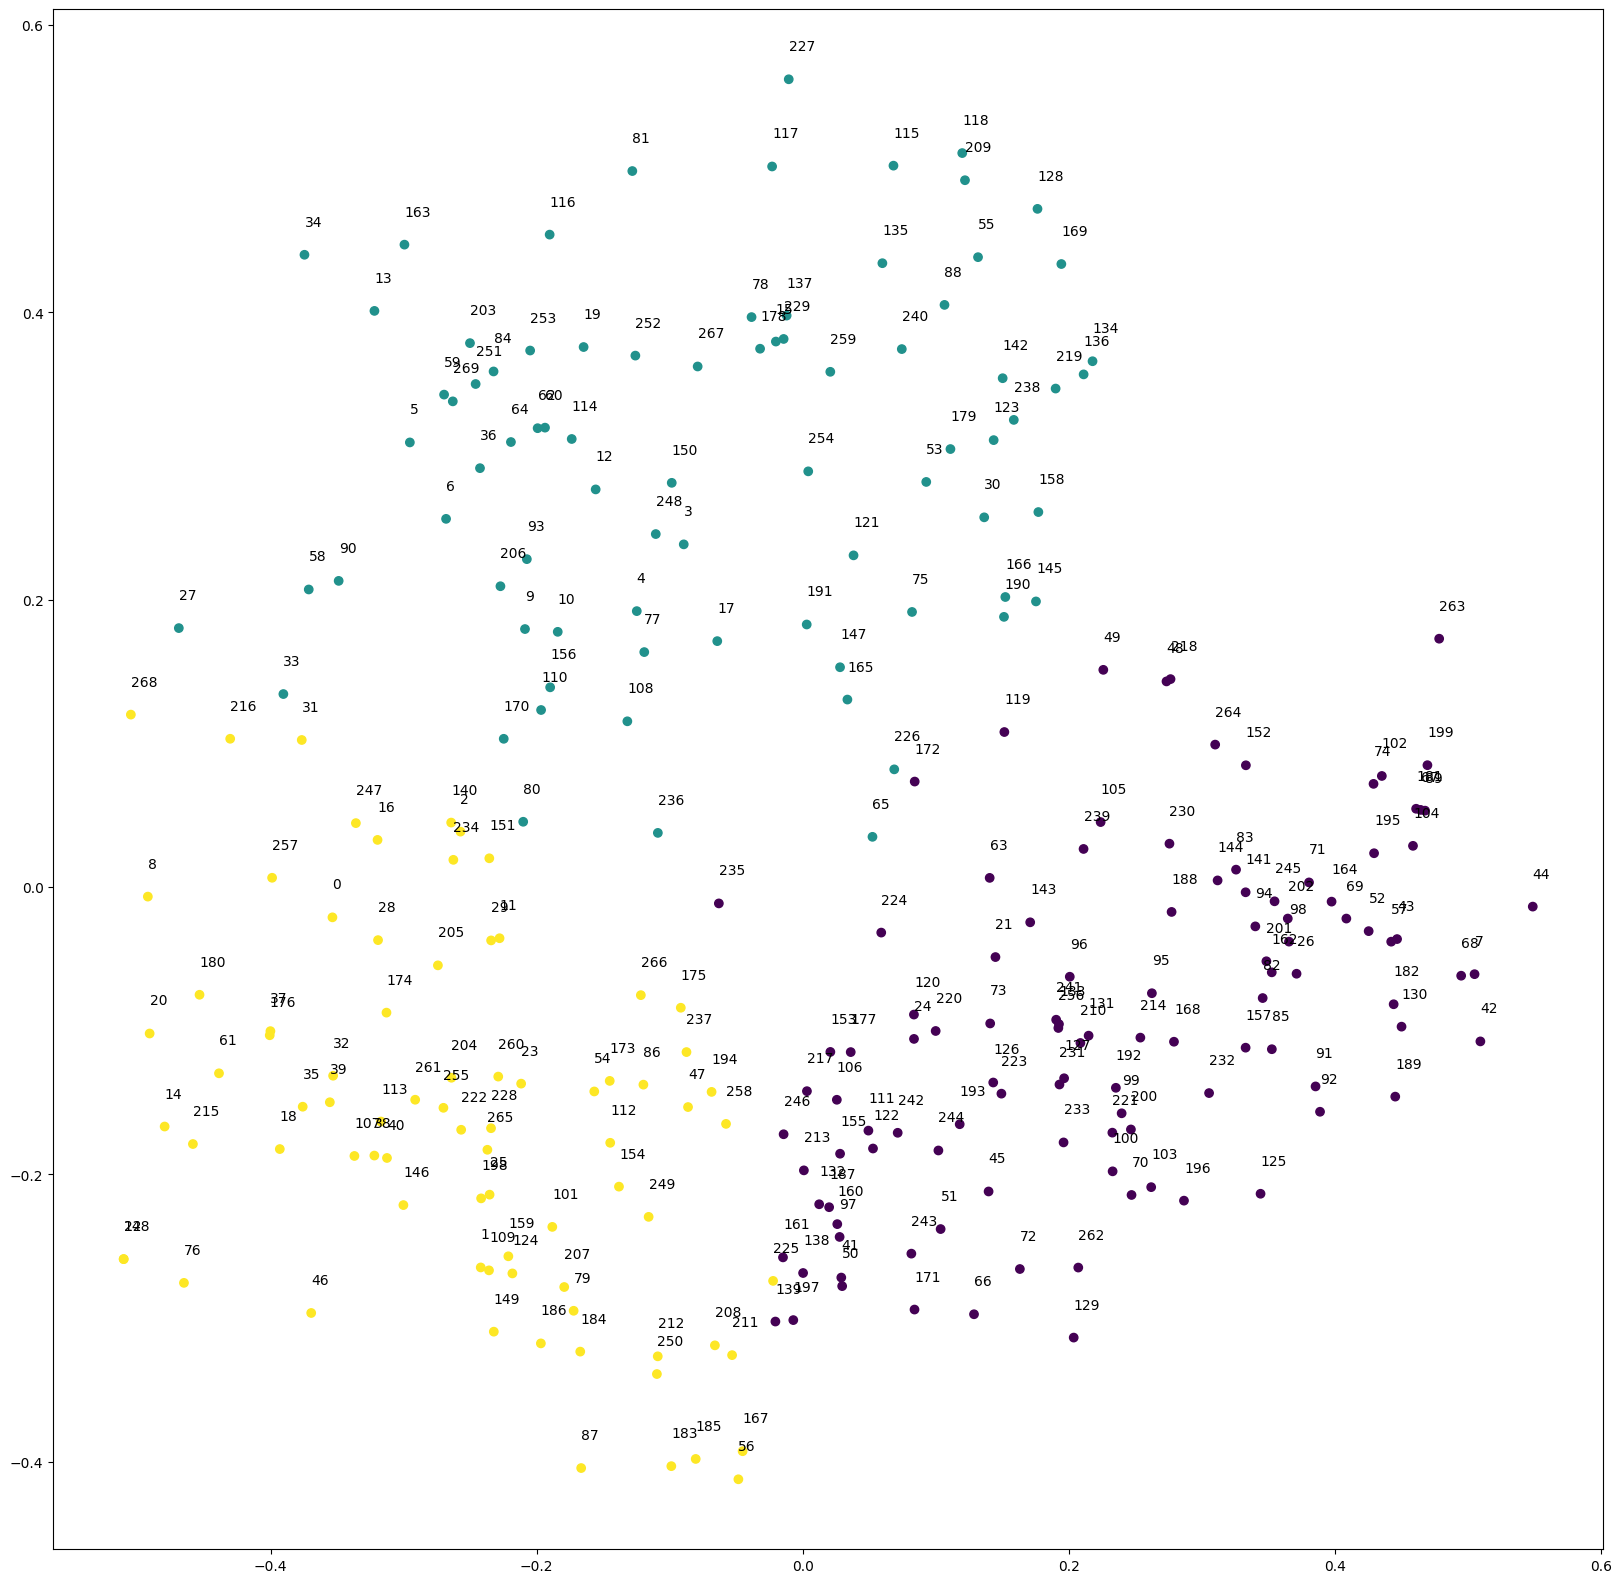

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
excerpt_sims = cosine_similarity(excerpt_emb, excerpt_emb)

S = np.linalg.eig(excerpt_sims)[0]
plt.scatter(range(len(S)), S)
plt.show()

from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='discretize', random_state=0).fit(excerpt_sims)
# for v in np.unique(clustering.labels_):
#     print(np.array(excerpts)[clustering.labels_ == v][:5])
sampled_ids = []
for v in np.unique(clustering.labels_):
    for cid in np.random.permutation(np.unique(np.array(dem_df['Corpus ID'])[clustering.labels_ == v]))[:5]:
        sampled_ids.append((np.array(dem_df['Corpus ID']) == cid).nonzero()[0][0])
        print(f"https://api.semanticscholar.org/CorpusID:{cid}")
    print()
sampled_ids = np.array(sampled_ids)

fig = plt.figure()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(excerpt_emb)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering.labels_)
# plt.scatter(X_pca[sampled_ids, 0], X_pca[sampled_ids, 1], c='k')

text = [str(i) for i in range(len(X_pca))]
for i in range(len(text)): 
    plt.annotate(text[i], (X_pca[i, 0], X_pca[i, 1] + 0.02)) 

fig.set_size_inches(20, 20)
plt.show()

In [16]:
centers = [
    [252, 259, 135, 19, 150],
    [61, 265, 174, 18, 54],
    [233, 141, 168, 95, 239],
]
for c in centers:
    for cid in c:
        print(f"https://api.semanticscholar.org/CorpusID:{dem_df['Corpus ID'].tolist()[cid]}")
    print()

https://api.semanticscholar.org/CorpusID:258947086
https://api.semanticscholar.org/CorpusID:259370652
https://api.semanticscholar.org/CorpusID:243847293
https://api.semanticscholar.org/CorpusID:52124316
https://api.semanticscholar.org/CorpusID:246285403

https://api.semanticscholar.org/CorpusID:226283588
https://api.semanticscholar.org/CorpusID:260063096
https://api.semanticscholar.org/CorpusID:248780152
https://api.semanticscholar.org/CorpusID:29645864
https://api.semanticscholar.org/CorpusID:221186851

https://api.semanticscholar.org/CorpusID:254877458
https://api.semanticscholar.org/CorpusID:243865399
https://api.semanticscholar.org/CorpusID:248218502
https://api.semanticscholar.org/CorpusID:235376822
https://api.semanticscholar.org/CorpusID:256461404



In [17]:
boundaries = [
    [236, 170, 33, 151, 216],
    [197, 246, 167, 258, 175],
    [65, 190, 224, 119, 49],
]
for b in boundaries:
    for bid in b:
        print(f"https://api.semanticscholar.org/CorpusID:{dem_df['Corpus ID'].tolist()[bid]}")
    print()

https://api.semanticscholar.org/CorpusID:256194532
https://api.semanticscholar.org/CorpusID:248266434
https://api.semanticscholar.org/CorpusID:218974227
https://api.semanticscholar.org/CorpusID:246285403
https://api.semanticscholar.org/CorpusID:252819136

https://api.semanticscholar.org/CorpusID:252438648
https://api.semanticscholar.org/CorpusID:258463933
https://api.semanticscholar.org/CorpusID:248177810
https://api.semanticscholar.org/CorpusID:259370569
https://api.semanticscholar.org/CorpusID:248780152

https://api.semanticscholar.org/CorpusID:226299699
https://api.semanticscholar.org/CorpusID:250390551
https://api.semanticscholar.org/CorpusID:253708271
https://api.semanticscholar.org/CorpusID:237365057
https://api.semanticscholar.org/CorpusID:220302524



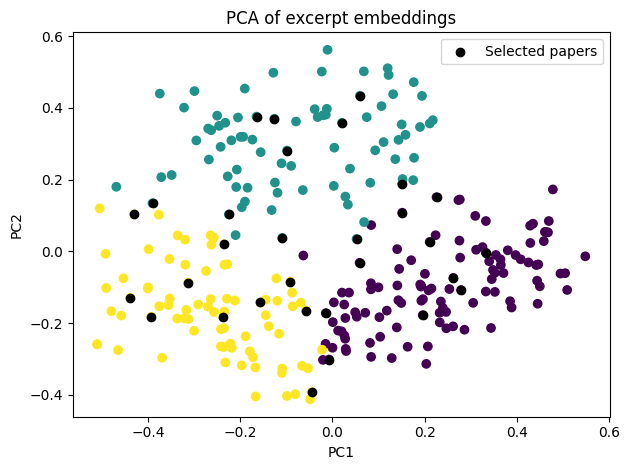

In [18]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering.labels_)
for idx, b in enumerate(boundaries + centers):
    if idx == 0:
        plt.scatter(X_pca[b, 0], X_pca[b, 1], c='k', label='Selected papers')
    else:
        plt.scatter(X_pca[b, 0], X_pca[b, 1], c='k')
    
fig.set_size_inches(5, 5)
plt.legend()
plt.title('PCA of excerpt embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.savefig('thematic-analysis-plots/clustering.pdf')
plt.show()